In [1]:
import faiss
assert faiss.get_num_gpus() > 0

In [24]:
import pandas as pd
# Helpful for showing indexing information
pd.set_option('display.max_colwidth', 150)

import os
import pyterrier as pt

if not pt.started():
    pt.init(tqdm='notebook',boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])
import onir_pt

import math


In [25]:
# import pyterrier_doc2query

In [26]:
df_anime=pd.read_csv('data_processed/anime_with_review.csv')
df_anime=df_anime.rename(columns={'uid':'docno'})
df_anime.head(1)

,docno,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link,wiki_link,anime_name,wiki_intro,review
0,28891,Haikyuu!! Second Season,"Following their participation at the Inter-High, the Karasuno High School volleyball team attempts to refocus their efforts, aiming to conquer the...","['Comedy', 'Sports', 'Drama', 'School', 'Shounen']","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/76662.jpg,https://myanimelist.net/anime/28891/Haikyuu_Second_Season,http://en.wikipedia.org/wiki/Haiky%C5%AB!!,Haikyū!!,"Junior high school student, Shoyo Hinata, becomes obsessed with volleyball after catching a glimpse of Karasuno High School playing in Nationals o...","Overall: 10 \r\n \r\nPlot: 10 \r\n \r\nHaikyuu! is a sports genre anime, mainly tackling about Volleyball. In this kind of story, there's only one..."


In [27]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545 entries, 0 to 4544
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   docno       4545 non-null   int64  
 1   title       4545 non-null   object 
 2   synopsis    4517 non-null   object 
 3   genre       4545 non-null   object 
 4   aired       4545 non-null   object 
 5   episodes    4527 non-null   float64
 6   members     4545 non-null   int64  
 7   popularity  4545 non-null   int64  
 8   ranked      4451 non-null   float64
 9   score       4545 non-null   float64
 10  img_url     4545 non-null   object 
 11  link        4545 non-null   object 
 12  wiki_link   4545 non-null   object 
 13  anime_name  4545 non-null   object 
 14  wiki_intro  4545 non-null   object 
 15  review      4545 non-null   object 
dtypes: float64(3), int64(3), object(10)
memory usage: 568.2+ KB


In [28]:
df_anime['docno']=df_anime['docno'].astype(str)
df_anime['title']=df_anime['title'].astype(str)
df_anime['synosis']=df_anime['synopsis'].astype(str)
df_anime['popularity']=df_anime['popularity'].astype(str)
df_anime['ranked']=df_anime['ranked'].astype(str)
df_anime['score']=df_anime['score'].astype(str)
df_anime['episodes']=df_anime['episodes'].astype(str)
df_anime['members']=df_anime['members'].astype(str)

In [29]:

pt_index_path = './pt_index_with_stemming'

if not os.path.exists(pt_index_path + "/data.properties"):

    indexer = pt.DFIndexer(pt_index_path,overwrite=True,blocks=True)
    index_ref = indexer.index(df_anime['synopsis'],df_anime['docno'],df_anime['title'],df_anime['synopsis'],df_anime['popularity'],df_anime['ranked'],df_anime['score'],df_anime['episodes'],df_anime['wiki_intro'],df_anime['review'])

else:
    # if you already have the index, create an IndexRef from the data in pt_index_path
    # that we can use to load using the IndexFactory
    # TODO
    index_ref = pt.IndexRef.of(pt_index_path+"/data.properties")
index = pt.IndexFactory.of(index_ref)

In [30]:
bm25_150 = pt.BatchRetrieve(index, wmodel="BM25")%150
bm25=pt.BatchRetrieve(index,wmodel='BM25')
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")

In [31]:
query=pd.read_csv('data_processed/query_list.csv')
query.reset_index(inplace=True)
query.rename(columns={'Query':'query','index':'qid'},inplace=True)
query['query']=query['query'].apply(lambda x:x.replace(','," "))
train_query=query[query['Train/Test']=='Train'].drop(columns=['Train/Test'])
test_query=query[query['Train/Test']=='Test'].drop(columns=['Train/Test'])

In [32]:
df_query=train_query.append(test_query)
df_query=df_query.reset_index().drop(columns=['index'])
df_query['query']=df_query['query'].apply(lambda x:x.replace(','," "))

In [33]:
print(index.getCollectionStatistics().toString())

Number of documents: 4517
Number of terms: 20551
Number of postings: 214508
Number of fields: 0
Number of tokens: 255416
Field names: []
Positions:   true



In [34]:

df_query_train=df_query[df_query['qid'].isin([0,1,2,3,4,5,6,7,8,9,20,21,22,23,24,25,26,27,28,29,30])]
df_query_train['qid']=df_query_train['qid'].astype('str')
df_label_train=pd.read_csv("labels.csv")
df_label_train['qid']=df_label_train['qid'].astype('str')
df_label_train['docno']=df_label_train['docno'].astype('str')
df_label_train['label']=df_label_train['label'].astype('int64')

df_query_test=df_query[df_query['qid'].isin([10,11,12,13,14,15,16,17,18,19,31,32,33,34,35,36,37,38,39,40])]
df_query_test['qid']=df_query_test['qid'].astype('str')
df_label_test=pd.read_csv("labels_test.csv")
df_label_test['qid']=df_label_test['qid'].astype('str')
df_label_test['docno']=df_label_test['docno'].astype('str')
df_label_test['label']=df_label_test['label'].astype('int64')

/tmp/ipykernel_500824/1490441622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query_train['qid']=df_query_train['qid'].astype('str')
/tmp/ipykernel_500824/1490441622.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query_test['qid']=df_query_test['qid'].astype('str')


In [10]:
df_label_train[df_label_train['label'].isna()]

,qid,docno,label


In [35]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)

pipeline_sdm=sdm>>bm25
pipeline_qe=bm25>>qe>>bm25

In [36]:

os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'


In [16]:

# from pyterrier_t5 import MonoT5ReRanker
# #DuoT5ReRanker
# monoT5 = MonoT5ReRanker(text_field='wiki_intro') # loads castorini/monot5-base-msmarco by default
# # duoT5 = DuoT5ReRanker(text_field='wiki_intro') # loads castorini/duot5-base-msmarco by default

# mono_pipeline = bm25 >> pt.text.get_text(index, ['wiki_intro']) >> monoT5
# # duo_pipeline = mono_pipeline % 50 >> duoT5 # apply a rank cutoff of 50 from monoT5 since duoT5 is too costly to run over the full result list

## Add re-rankers

In [17]:
import onir_pt

knrm = onir_pt.reranker.from_checkpoint('https://macavaney.us/knrm.medmarco.tar.gz', text_field='wiki_intro', 
                                        expected_md5="d70b1d4f899690dae51161537e69ed5a")
vbert = onir_pt.reranker.from_checkpoint('https://macavaney.us/scibert-medmarco.tar.gz', 
                                         text_field='wiki_intro', expected_md5="854966d0b61543ffffa44cea627ab63b")

config file not found: config
[2022-12-16 12:37:43,590][onir_pt][INFO] using cached checkpoint: /home/zihuiliu/data/onir/model_checkpoints/b7694d2fb4d4f8218e11734de239ad30
[2022-12-16 12:37:43,597][WordvecHashVocab][DEBUG] [starting] reading cached at /home/zihuiliu/data/onir/vocab/wordvec_hash/fasttext-wiki-news-300d-1M.p
[2022-12-16 12:37:44,932][WordvecHashVocab][DEBUG] [finished] reading cached at /home/zihuiliu/data/onir/vocab/wordvec_hash/fasttext-wiki-news-300d-1M.p [1.34s]
[2022-12-16 12:37:49,522][onir_pt][INFO] using cached checkpoint: /home/zihuiliu/data/onir/model_checkpoints/1153203ea2abbdf7f760fa6956a83d83


## Add Query Expansion

In [18]:
# if not os.path.exists("t5-base.zip"):
#   !wget https://git.uwaterloo.ca/jimmylin/doc2query-data/raw/master/T5-passage/t5-base.zip
#   !unzip t5-base.zip


# doc2query = pyterrier_doc2query.Doc2Query('model.ckpt-1004000', batch_size=8)

In [19]:

# indexer = ((pyterrier_doc2query.Doc2Query('model.ckpt-1004000', doc_attr='title', batch_size=8, append=True))
#     >> pt.apply.generic(lambda df: df.rename(columns={'title': 'text'}))
#     >> pt.IterDictIndexer("./doc2query_index_path")) # index the expanded documents

# indexref_doc2query = indexer.index(df_anime['synopsis'],df_anime['docno'],df_anime['title'],df_anime['popularity'],df_anime['ranked'],df_anime['score'],df_anime['episodes'],df_anime['wiki_intro'],df_anime['review'])



In [20]:
# pipeline = pt.BatchRetrieve(doc2query_indexref) % 1 >> pt.text.get_text(dataset, 'title')

# Learning to Rank

In [40]:
RANK_CUTOFF = 50
SEED=42

from sklearn.model_selection import train_test_split

# train_topics, val_topics = train_test_split(train_query, test_size=0.2, random_state=SEED)

ltr_feats1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ['docno', 'title', 'synopsis' ,'popularity', 'wiki_intro', 'review']) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", wmodel='TF_IDF')*3
    +pt.text.scorer(body_attr="synopsis",wmodel='BM25')*2+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')*1
    +pt.text.scorer(body_attr="review",wmodel='BM25')) 
    **
    (pt.apply.doc_score(lambda row: int(row["popularity"])))
    **
    (pt.apply.doc_score(lambda row: 0 if row["wiki_intro"]=="none" else 1))
#     ** # has doi
#     (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0) ))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)   

fnames1=["BM25", "SDM", 'overall_test_score', 'popularity', "has_wii",  "CoordinateMatch"]

In [41]:
ltr_feats2 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ['docno', 'title', 'synopsis','popularity', 'wiki_intro', 'review'])>> knrm >> (
    pt.transformer.IdentityTransformer()
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", wmodel='TF_IDF')*3
    +pt.text.scorer(body_attr="synopsis",wmodel='BM25')*2+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')*2
    +pt.text.scorer(body_attr="review",wmodel='BM25')) 
    **
    (pt.apply.doc_score(lambda row: int(math.log((int)(row["popularity"])))))
    **
    (pt.apply.doc_score(lambda row: 0 if row["wiki_intro"]=="none" else 1))
#     ** # has doi
#     (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0) ))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [42]:
ltr_feats3 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ['docno', 'title', 'synopsis','popularity', 'wiki_intro', 'review'])>> vbert >> (
    pt.transformer.IdentityTransformer()
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", wmodel='TF_IDF')*3
    +pt.text.scorer(body_attr="synopsis",wmodel='BM25')*2+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')*2
    +pt.text.scorer(body_attr="review",wmodel='BM25')) 
    **
    (pt.apply.doc_score(lambda row: int(math.log((int)(row["popularity"])))))
    **
    (pt.apply.doc_score(lambda row: 0 if row["wiki_intro"]=="none" else 1))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [43]:
ltr_feats4 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ['docno', 'title', 'synopsis','score', 'wiki_intro', 'review','popularity'])>> knrm >> (
    pt.transformer.IdentityTransformer()
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", wmodel='TF_IDF')
    +pt.text.scorer(body_attr="synopsis",wmodel='BM25')+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')
    +pt.text.scorer(body_attr="review",wmodel='BM25'))
    **
    (pt.apply.doc_score(lambda row: int(math.log((int)(row["popularity"])))))
    **
    (pt.apply.doc_score(lambda row: 0 if row["wiki_intro"]=="none" else 1))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [44]:
## add query expansion based on ltr_feats4

ltr_feats4_1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ['docno', 'title', 'synopsis','score', 'wiki_intro', 'review','popularity'])>> knrm >> (
    pt.transformer.IdentityTransformer()
    ** 
    pipeline_qe
    **
    (pt.text.scorer(body_attr="title", wmodel='TF_IDF')*3
    +pt.text.scorer(body_attr="synopsis",wmodel='BM25')*2+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')*2
    +pt.text.scorer(body_attr="review",wmodel='BM25'))
    **
    (pt.apply.doc_score(lambda row: int(math.log((int)(row["popularity"])))))
    **
    (pt.apply.doc_score(lambda row: 0 if row["wiki_intro"]=="none" else 1))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [45]:
ltr_feats5 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ['docno', 'title', 'synopsis','score', 'wiki_intro', 'review','popularity'])>> vbert >> (
    pt.transformer.IdentityTransformer()
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", wmodel='TF_IDF')
    +pt.text.scorer(body_attr="synopsis",wmodel='BM25')+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')
    +pt.text.scorer(body_attr="review",wmodel='BM25'))
    **
    (pt.apply.doc_score(lambda row: int(math.log((int)(row["popularity"])))))
    **
    (pt.apply.doc_score(lambda row: 0 if row["wiki_intro"]=="none" else 1))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [46]:
## add query expansion based on ltr_feats5

ltr_feats5_1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ['docno', 'title', 'synopsis','score', 'wiki_intro', 'review','popularity'])>> vbert >> (
    pt.transformer.IdentityTransformer()
    **
    pipeline_qe
    ** # score of title (not originally indexed)
    
    (pt.text.scorer(body_attr="title", wmodel='TF_IDF')*3
    +pt.text.scorer(body_attr="synopsis",wmodel='BM25')*2+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')*2
    +pt.text.scorer(body_attr="review",wmodel='BM25'))
    **
    (pt.apply.doc_score(lambda row: int(math.log((int)(row["popularity"])))))
    **
    (pt.apply.doc_score(lambda row: 0 if row["wiki_intro"]=="none" else 1))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

fnames5_1=["basemodel", "qe", 'overall_test_score_2', 'log_popularity', "has_wiki",  "CoordinateMatch"]

In [47]:
## add query expansion based on ltr_feats4

# ltr_feats4_1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ['docno', 'title', 'synopsis','score', 'wiki_intro', 'review','popularity'])>> knrm >> (
#     pt.transformer.IdentityTransformer()
#     ** 
#     pipeline_qe
#     **
#     (pt.text.scorer(body_attr="title", wmodel='TF_IDF')
#     +pt.text.scorer(body_attr="synopsis",wmodel='BM25')+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')
#     +pt.text.scorer(body_attr="review",wmodel='BM25'))
#     **
#     (pt.apply.doc_score(lambda row: int(math.log((int)(row["popularity"])))))
#     **
#     (pt.apply.doc_score(lambda row: 0 if row["wiki_intro"]=="none" else 1))
#     ** # abstract coordinate match
#     pt.BatchRetrieve(index, wmodel="CoordinateMatch")
# )

In [48]:
import fastrank

train_request1 = fastrank.TrainRequest.coordinate_ascent()
params = train_request1.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe1 = ltr_feats1 >> pt.ltr.apply_learned_model(train_request1, form='fastrank')
ca_pipe2 = ltr_feats2 >> pt.ltr.apply_learned_model(train_request1, form='fastrank')
ca_pipe3 = ltr_feats3 >> pt.ltr.apply_learned_model(train_request1, form='fastrank')
ca_pipe4 = ltr_feats4 >> pt.ltr.apply_learned_model(train_request1, form='fastrank')
ca_pipe5 = ltr_feats5 >> pt.ltr.apply_learned_model(train_request1, form='fastrank')
ca_pipe4_1 = ltr_feats4_1 >> pt.ltr.apply_learned_model(train_request1, form='fastrank')
ca_pipe5_1 = ltr_feats5_1 >> pt.ltr.apply_learned_model(train_request1, form='fastrank')

%time ca_pipe1.fit(train_query, df_label_train)
%time ca_pipe2.fit(train_query, df_label_train)

%time ca_pipe3.fit(train_query, df_label_train)
%time ca_pipe4.fit(train_query, df_label_train)
%time ca_pipe5.fit(train_query, df_label_train)
%time ca_pipe4_1.fit(train_query, df_label_train)
%time ca_pipe5_1.fit(train_query, df_label_train)


12:55:58.874 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:55:59.489 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:56:00.328 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:56:02.417 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 12:56:20,269][onir_pt][DEBUG] [finished] batches: s] [263it] [529.05it/s]
12:56:20.558 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:56:21.172 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:56:21.999 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:56:24.216 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 12:57:00,347][onir_pt][DEBUG] [finished] batches: [18.87s] [263it] [13.94it/s]
12:57:00.635 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:57:01.251 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:57:02.088 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:57:04.244 [main] WARN org.terrier.querying.ApplyTermPipeline

batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 12:57:22,226][onir_pt][DEBUG] [finished] batches: s] [263it] [544.96it/s]
12:57:22.519 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:57:23.145 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:57:23.955 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:57:26.171 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 12:58:02,518][onir_pt][DEBUG] [finished] batches: [18.88s] [263it] [13.93it/s]
12:58:02.808 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:58:03.433 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:58:04.266 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:58:06.345 [main] WARN org.terrier.querying.ApplyTermPipeline

batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 12:58:24,370][onir_pt][DEBUG] [finished] batches: s] [263it] [547.75it/s]
12:58:43.860 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:58:44.478 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:58:45.312 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:58:47.389 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
   0|0         

batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 12:59:23,894][onir_pt][DEBUG] [finished] batches: [18.89s] [263it] [13.93it/s]
12:59:43.710 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:59:44.324 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:59:45.161 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:59:47.213 [main] WARN org.terrier.querying.ApplyTermPipeline

In [49]:
from sklearn.ensemble import RandomForestRegressor

rf1 = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf2 = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf3 = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf4 = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf5 = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf4_1 = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf5_1 = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe1 = ltr_feats1 >> pt.ltr.apply_learned_model(rf1)
rf_pipe2 = ltr_feats2 >> pt.ltr.apply_learned_model(rf2)
rf_pipe3 = ltr_feats3 >> pt.ltr.apply_learned_model(rf3)
rf_pipe4 = ltr_feats4 >> pt.ltr.apply_learned_model(rf4)
rf_pipe5 = ltr_feats5 >> pt.ltr.apply_learned_model(rf5)
rf_pipe4_1 = ltr_feats4_1 >> pt.ltr.apply_learned_model(rf4_1)
rf_pipe5_1 = ltr_feats5_1 >> pt.ltr.apply_learned_model(rf5_1)
%time rf_pipe1.fit(train_query, df_label_train)
%time rf_pipe2.fit(train_query, df_label_train)
%time rf_pipe3.fit(train_query, df_label_train)
%time rf_pipe4.fit(train_query, df_label_train)
%time rf_pipe5.fit(train_query, df_label_train)
%time rf_pipe4_1.fit(train_query, df_label_train)
%time rf_pipe5_1.fit(train_query, df_label_train)

13:00:06.149 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:00:06.763 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:00:07.612 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:00:09.994 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.8s finished


CPU times: user 26.2 s, sys: 1.61 s, total: 27.8 s
Wall time: 23.4 s
[2022-12-16 13:00:28,091][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:00:28,093][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:00:28,591][onir_pt][DEBUG] [finished] batches: s] [263it] [529.64it/s]
13:00:28.886 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:00:29.508 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:00:30.348 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:00:32.584 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.6s finished


CPU times: user 22.7 s, sys: 1 s, total: 23.7 s
Wall time: 22.4 s
[2022-12-16 13:00:50,471][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:00:50,475][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:01:09,353][onir_pt][DEBUG] [finished] batches: [18.88s] [263it] [13.93it/s]
13:01:09.646 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:01:10.278 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:01:11.276 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:01:13.525 [main] WARN org.terrier.querying.ApplyTermPipeline

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.7s finished


CPU times: user 41 s, sys: 1.11 s, total: 42.1 s
Wall time: 41 s
[2022-12-16 13:01:31,748][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:01:31,750][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:01:32,233][onir_pt][DEBUG] [finished] batches: s] [263it] [545.91it/s]
13:01:32.531 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:01:33.166 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:01:34.003 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:01:36.206 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.6s finished


CPU times: user 22.7 s, sys: 1.19 s, total: 23.9 s
Wall time: 22.6 s
[2022-12-16 13:01:54,362][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:01:54,367][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:02:13,263][onir_pt][DEBUG] [finished] batches: [18.90s] [263it] [13.92it/s]
13:02:13.561 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:02:14.202 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:02:15.043 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:02:17.124 [main] WARN org.terrier.querying.ApplyTermPipeline

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.7s finished


CPU times: user 40.9 s, sys: 1.19 s, total: 42.1 s
Wall time: 40.9 s
[2022-12-16 13:02:35,300][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:02:35,301][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:02:35,802][onir_pt][DEBUG] [finished] batches: s] [263it] [526.06it/s]
13:02:55.243 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:02:55.848 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:02:56.690 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:02:58.924 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

CPU times: user 42.9 s, sys: 1.24 s, total: 44.1 s
Wall time: 41.9 s
[2022-12-16 13:03:17,439][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:03:17,443][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:03:36,318][onir_pt][DEBUG] [finished] batches: [18.87s] [263it] [13.93it/s]
13:03:55.760 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:03:56.378 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:03:57.217 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:03:59.292 [main] WARN org.terrier.querying.ApplyTermPipeline

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

CPU times: user 1min 1s, sys: 1.3 s, total: 1min 2s
Wall time: 1min


In [50]:


import lightgbm as lgb


train_topics, val_topics = train_test_split(train_query, test_size=0.2, random_state=SEED)

# this configures LightGBM as LambdaMART
lmart_l1 = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
# this configures LightGBM as LambdaMART
lmart_l2 = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
lmart_l3 = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
lmart_l4 = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
lmart_l5 = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
lmart_l4_1 = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
lmart_l5_1 = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)
lmart_x_pipe1 = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l1, form="ltr", fit_kwargs={'eval_at':[10]})
lmart_x_pipe2 = ltr_feats2 >> pt.ltr.apply_learned_model(lmart_l2, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe3 = ltr_feats3 >> pt.ltr.apply_learned_model(lmart_l3, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe4 = ltr_feats4 >> pt.ltr.apply_learned_model(lmart_l4, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe5 = ltr_feats5 >> pt.ltr.apply_learned_model(lmart_l5, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe4_1 = ltr_feats4_1 >> pt.ltr.apply_learned_model(lmart_l4_1, form="ltr", fit_kwargs={'eval_at':[10]})

lmart_x_pipe5_1 = ltr_feats5_1 >> pt.ltr.apply_learned_model(lmart_l5_1, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmart_x_pipe1.fit(train_topics, df_label_train, val_topics, df_label_train)

%time lmart_x_pipe2.fit(train_topics, df_label_train, val_topics, df_label_train)

%time lmart_x_pipe3.fit(train_topics, df_label_train, val_topics, df_label_train)

%time lmart_x_pipe4.fit(train_topics, df_label_train, val_topics, df_label_train)

%time lmart_x_pipe5.fit(train_topics, df_label_train, val_topics, df_label_train)

%time lmart_x_pipe4_1.fit(train_topics, df_label_train, val_topics, df_label_train)

%time lmart_x_pipe5_1.fit(train_topics, df_label_train, val_topics, df_label_train)




13:04:14.768 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:04:15.232 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:04:15.832 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:04:17.388 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 800, n

batches:   0%|          | 0/200 s<?, ?it/s]

[2022-12-16 13:04:36,478][onir_pt][DEBUG] [finished] batches: s] [200it] [557.22it/s]
13:04:36.700 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:04:37.165 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:04:37.767 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:04:39.259 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

batches:   0%|          | 0/63 s<?, ?it/s]

[2022-12-16 13:04:43,999][onir_pt][DEBUG] [finished] batches: s] [63it] [412.74it/s]
13:04:44.091 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:04:44.268 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:04:44.526 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:04:45.153 [main] WARN org.terrier.querying.ApplyTermPipeline - The

/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 800, nu

batches:   0%|          | 0/200 s<?, ?it/s]

[2022-12-16 13:05:11,457][onir_pt][DEBUG] [finished] batches: [13.52s] [200it] [14.79it/s]
13:05:11.683 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:12.144 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:12.726 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:14.337 [main] WARN org.terrier.querying.ApplyTermPipeline

batches:   0%|          | 0/63 s<?, ?it/s]

[2022-12-16 13:05:24,406][onir_pt][DEBUG] [finished] batches: [5.48s] [63it] [11.49it/s]
13:05:24.496 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:24.673 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:24.929 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:25.555 [main] WARN org.terrier.querying.ApplyTermPipeline -

/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 800, nu

batches:   0%|          | 0/200 s<?, ?it/s]

[2022-12-16 13:05:38,876][onir_pt][DEBUG] [finished] batches: s] [200it] [549.37it/s]
13:05:39.097 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:39.578 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:40.177 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:41.662 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

batches:   0%|          | 0/63 s<?, ?it/s]

[2022-12-16 13:05:46,410][onir_pt][DEBUG] [finished] batches: s] [63it] [440.07it/s]
13:05:46.500 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:46.685 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:46.944 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:05:47.552 [main] WARN org.terrier.querying.ApplyTermPipeline - The

/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 800, nu

batches:   0%|          | 0/200 s<?, ?it/s]

[2022-12-16 13:06:14,137][onir_pt][DEBUG] [finished] batches: [13.51s] [200it] [14.80it/s]
13:06:14.362 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:14.836 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:15.441 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:17.019 [main] WARN org.terrier.querying.ApplyTermPipeline

batches:   0%|          | 0/63 s<?, ?it/s]

[2022-12-16 13:06:27,115][onir_pt][DEBUG] [finished] batches: [5.47s] [63it] [11.52it/s]
13:06:27.206 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:27.392 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:27.653 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:28.247 [main] WARN org.terrier.querying.ApplyTermPipeline -

/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 800, nu

batches:   0%|          | 0/200 s<?, ?it/s]

[2022-12-16 13:06:41,618][onir_pt][DEBUG] [finished] batches: s] [200it] [556.44it/s]
13:06:56.424 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:56.886 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:57.472 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:58.953 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

[2022-12-16 13:07:03,866][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:07:03,868][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/63 s<?, ?it/s]

[2022-12-16 13:07:04,013][onir_pt][DEBUG] [finished] batches: s] [63it] [438.64it/s]
13:07:08.824 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:09.002 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:09.261 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:09.887 [main] WARN org.terrier.querying.ApplyTermPipeline - The

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 800, nu

batches:   0%|          | 0/200 s<?, ?it/s]

[2022-12-16 13:07:36,339][onir_pt][DEBUG] [finished] batches: [13.52s] [200it] [14.80it/s]
13:07:50.947 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:51.414 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:52.016 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:53.632 [main] WARN org.terrier.querying.ApplyTermPipeline

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

[2022-12-16 13:07:58,294][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:07:58,298][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/63 s<?, ?it/s]

[2022-12-16 13:08:03,782][onir_pt][DEBUG] [finished] batches: [5.48s] [63it] [11.49it/s]
13:08:08.612 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:08:08.794 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:08:09.054 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:08:09.681 [main] WARN org.terrier.querying.ApplyTermPipeline -

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 780
[LightGBM] [Info] Number of data points in the train set: 800, nu

## Evaluate baseline

### Naive random baseline

In [17]:
import random

def random_weighting(keyFreq, posting, entryStats, collStats):
    '''
    Computes the Pivoted Normalization score of this document for a given query
    
    :param keyFrequency(float): the weight of the term in the query, usually 1 except during PRF.
    :param posting(Posting): access to the information about the occurrence of the term in the current document (frequency, document length etc).
    :param entryStats(EntryStatistics): access to the information about the occurrence of the term in the whole index (document frequency, etc.).
    :param collStats(CollectionStatistics): access to the information about the index as a whole (number of documents, etc).
    :return: the Pivoted Normalization score of this document for the given query
    '''
    return random.random()
random_model=pt.BatchRetrieve(index,wmodel=random_weighting)

In [52]:
# pt.Experiment(
#     [
#     bm25,
#     mono_pipeline,
#     duo_pipeline,
#     ],
#     df_query_train,
#     df_label_train,
#     names=["BM25", "BM25 >> monoT5","BM25 >> monoT5 >> duo"],
#     eval_metrics=["map", "ndcg"]
# )

In [53]:
from pyterrier.measures import *

# training set
pt.Experiment(
    [bm25,bm25_150,random_model,tf_idf,ca_pipe1,rf_pipe1,lmart_x_pipe1,ca_pipe2,rf_pipe2,lmart_x_pipe2,ca_pipe3,rf_pipe3,lmart_x_pipe3,
     ca_pipe4,rf_pipe4,lmart_x_pipe4,ca_pipe5,rf_pipe5,lmart_x_pipe5,ca_pipe4_1,rf_pipe4_1,lmart_x_pipe4_1,ca_pipe5_1,rf_pipe5_1,lmart_x_pipe5_1],
    df_query_train,
    df_label_train,
    names=["BM25","BM25_150","Naive","TF_IDF","CA1","RF1","lmart1","CA_knrm","RF_knrm","lmart_knrm","CA_bert","RF_bert","lmart_bert",
              "CA_knrm_revised","RF_knrm_revised","lmart_knrm_revised","CA_bert_revised","RF_bert_revised","lmart_bert_revised",
              "CA_knrm_revised_qe","RF_knrm_revised_qe","lmart_knrm_revised_qe","CA_bert_revised_qe","RF_bert_revised_qe","lmart_bert_revised_qe"], 
    eval_metrics=["map", "ndcg",nDCG@5,nDCG@10,nDCG@15,nDCG@20,'P.10','mrt',Recall@15])
# ,"RF1","LMart1" rf_pipe1,lmart_x_pipe1

13:09:27.391 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:09:28.007 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:09:28.831 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:09:31.038 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


13:10:11.635 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:10:12.221 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:10:13.042 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:10:15.240 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[2022-12-16 13:10:32,304][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:10:32,306][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:10:32,807][onir_pt][DEBUG] [finished] batches: s] [263it] [526.69it/s]
13:10:33.093 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:10:33.703 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:10:34.531 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:10:36.586 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:10:54,100][onir_pt][DEBUG] [finished] batches: s] [263it] [546.39it/s]
13:10:54.391 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:10:55.001 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:10:55.782 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:10:57.993 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


[2022-12-16 13:11:15,180][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:11:15,183][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:11:15,668][onir_pt][DEBUG] [finished] batches: s] [263it] [543.40it/s]
13:11:15.958 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:16.572 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:17.398 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:19.429 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[2022-12-16 13:11:36,739][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:11:36,743][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:11:55,477][onir_pt][DEBUG] [finished] batches: [18.73s] [263it] [14.04it/s]
13:11:55.765 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:56.375 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:57.201 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:59.350 [main] WARN org.terrier.querying.ApplyTermPipeline

batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:12:35,103][onir_pt][DEBUG] [finished] batches: [18.73s] [263it] [14.04it/s]
13:12:35.390 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:35.999 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:36.822 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:38.861 [main] WARN org.terrier.querying.ApplyTermPipeline

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


[2022-12-16 13:12:56,050][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:12:56,054][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:13:14,789][onir_pt][DEBUG] [finished] batches: [18.73s] [263it] [14.04it/s]
13:13:15.076 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:15.659 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:16.482 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:18.692 [main] WARN org.terrier.querying.ApplyTermPipeline

/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[2022-12-16 13:13:35,994][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:13:35,995][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:13:36,477][onir_pt][DEBUG] [finished] batches: s] [263it] [547.46it/s]
13:13:36.762 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:37.385 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:38.209 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:40.358 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:13:58,120][onir_pt][DEBUG] [finished] batches: s] [263it] [545.77it/s]
13:13:58.402 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:59.025 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:59.855 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:14:01.909 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


[2022-12-16 13:14:19,337][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:14:19,339][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:14:19,825][onir_pt][DEBUG] [finished] batches: s] [263it] [542.45it/s]
13:14:20.121 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:14:20.732 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:14:21.565 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:14:23.711 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[2022-12-16 13:14:41,043][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:14:41,047][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:14:59,779][onir_pt][DEBUG] [finished] batches: [18.73s] [263it] [14.04it/s]
13:15:00.066 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:15:00.691 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:15:01.500 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:15:03.684 [main] WARN org.terrier.querying.ApplyTermPipeline

batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:15:39,745][onir_pt][DEBUG] [finished] batches: [18.75s] [263it] [14.03it/s]
13:15:40.030 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:15:40.667 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:15:41.498 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:15:43.538 [main] WARN org.terrier.querying.ApplyTermPipeline

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


[2022-12-16 13:16:00,939][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:16:00,943][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:16:19,682][onir_pt][DEBUG] [finished] batches: [18.74s] [263it] [14.04it/s]
13:16:19.965 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:16:20.680 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:16:21.492 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:16:23.560 [main] WARN org.terrier.querying.ApplyTermPipeline

/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/zihuiliu/.local/lib/python3.9/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[2022-12-16 13:16:40,900][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:16:40,902][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:16:41,384][onir_pt][DEBUG] [finished] batches: s] [263it] [547.01it/s]
13:17:01.021 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:17:01.629 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:17:02.447 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:17:04.488 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

[2022-12-16 13:17:21,917][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:17:21,919][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:17:22,415][onir_pt][DEBUG] [finished] batches: s] [263it] [531.16it/s]
13:17:42.352 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:17:42.959 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:17:43.776 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:17:45.959 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


[2022-12-16 13:18:03,424][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:18:03,426][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:18:03,911][onir_pt][DEBUG] [finished] batches: s] [263it] [543.83it/s]
13:18:23.276 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:18:23.874 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:18:24.693 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:18:26.888 [main] WARN org.terrier.querying.ApplyTermPipeline - Th

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[2022-12-16 13:18:44,210][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:18:44,215][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:19:02,949][onir_pt][DEBUG] [finished] batches: [18.73s] [263it] [14.04it/s]
13:19:22.312 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:19:22.919 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:19:23.744 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:19:25.942 [main] WARN org.terrier.querying.ApplyTermPipeline

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

[2022-12-16 13:19:43,255][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:19:43,259][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:20:01,991][onir_pt][DEBUG] [finished] batches: [18.73s] [263it] [14.04it/s]
13:20:21.348 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:20:21.956 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:20:22.775 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:20:24.905 [main] WARN org.terrier.querying.ApplyTermPipeline

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


[2022-12-16 13:20:42,669][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-16 13:20:42,672][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/263 s<?, ?it/s]

[2022-12-16 13:21:01,414][onir_pt][DEBUG] [finished] batches: [18.74s] [263it] [14.03it/s]
13:21:20.810 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:21:21.426 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:21:22.252 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:21:24.461 [main] WARN org.terrier.querying.ApplyTermPipeline

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1


,name,map,ndcg,nDCG@5,nDCG@10,nDCG@15,nDCG@20,P.10,R@15,mrt
0,BM25,0.630514,0.786125,0.559727,0.502798,0.492524,0.488709,0.650,0.114582,675.941540
1,BM25_150,0.612363,0.763037,0.559727,0.502798,0.492524,0.488709,0.650,0.114582,662.152095
2,Naive,0.291667,0.637120,0.389659,0.362476,0.357605,0.341308,0.565,0.092485,852.001893
3,TF_IDF,0.625334,0.783971,0.564368,0.504252,0.491442,0.483209,0.655,0.114529,661.993172
4,CA1,0.277807,0.439155,0.663294,0.583691,0.547507,0.541970,0.760,0.128659,1048.896190
5,RF1,0.352824,0.516040,0.957636,0.898719,0.853401,0.809258,0.995,0.178357,1056.964878
6,lmart1,0.284190,0.457177,0.741779,0.663024,0.616516,0.594127,0.805,0.132971,1047.315683
7,CA_knrm,0.269604,0.430112,0.590949,0.535021,0.521639,0.515467,0.700,0.126703,1013.409772
8,RF_knrm,0.344126,0.506895,0.922398,0.867104,0.815944,0.768574,0.975,0.174404,1025.568300
9,lmart_knrm,0.263721,0.415534,0.515152,0.505861,0.496936,0.490929,0.710,0.125132,1014.486786


In [47]:
kl = pt.rewrite.KLQueryExpansion(index)
kl_pipe = bm25 >> kl >> bm25

## delete has_wiki and CoordinateMatch based on ltr_feats5_1, edit rank_cutoff

RANK_CUTOFF2=50

ltr_feats1_1 = (bm25 % RANK_CUTOFF2) >> pt.text.get_text(index, ['docno', 'title', 'synopsis','score', 'wiki_intro', 'review','popularity',]) >> (
    pt.transformer.IdentityTransformer()
    **
    sdm
    **
    kl_pipe
    ** # score of title (not originally indexed)
    
    (pt.text.scorer(body_attr="title", wmodel='TF_IDF')*3
    +pt.text.scorer(body_attr="synopsis",wmodel='BM25')*2+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')*2
    +pt.text.scorer(body_attr="review",wmodel='BM25'))
    **
    (pt.apply.doc_score(lambda row: int(math.log((int)(row["popularity"])))))
    **
    (pt.apply.doc_score(lambda row: 0 if row["wiki_intro"]=="none" else 1))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

fnames1_1=["BM25","sdm", "kl", 'overall_test_score', 'popularity', "has_wiki",  "coordinate_match"]



ltr_feats1_2 = (bm25 % RANK_CUTOFF2) >> pt.text.get_text(index, ['docno', 'title', 'synopsis','score', 'wiki_intro', 'review','popularity',])>>  (
    pt.transformer.IdentityTransformer()
    **
    sdm
    **
    pipeline_qe
    ** # score of title (not originally indexed)
    
    (pt.text.scorer(body_attr="title", wmodel='TF_IDF')*3
    +pt.text.scorer(body_attr="synopsis",wmodel='BM25')*2+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')*2
    +pt.text.scorer(body_attr="review",wmodel='BM25'))
    **
    (pt.apply.doc_score(lambda row: int(math.log((int)(row["popularity"])))))
    **
    (pt.apply.doc_score(lambda row: 0 if row["wiki_intro"]=="none" else 1))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

fnames1_2=["BM25","sdm", "qe", 'overall_test_score', 'popularity', "has_wiki",  "coordinate_match"]

In [48]:
from sklearn.ensemble import RandomForestRegressor
RANK_CUTOFF = 50
SEED=42

rf1_1 = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe1_1 = ltr_feats1_1 >> pt.ltr.apply_learned_model(rf1_1)
%time rf_pipe1_1.fit(train_query, df_label_train)
rf1_2 = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe1_2 = ltr_feats1_2 >> pt.ltr.apply_learned_model(rf1_2)
%time rf_pipe1_2.fit(train_query, df_label_train)


14:10:04.687 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:10:05.306 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:10:06.144 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:10:08.311 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

CPU times: user 42.9 s, sys: 1.39 s, total: 44.3 s
Wall time: 41.7 s
14:10:46.058 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:10:46.680 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:10:47.509 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:10:49.690 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no te

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

CPU times: user 42.7 s, sys: 1.25 s, total: 43.9 s
Wall time: 41.4 s


In [49]:
from pyterrier.measures import *

# training set
pt.Experiment(
    [bm25,bm25_150,random_model,rf_pipe1_1,rf_pipe1_2],
    df_query_train,
    df_label_train,
    names=["BM25","BM25_150","Naive","rf_kl","rf_qe"], 
    eval_metrics=["map", "ndcg",nDCG@5,nDCG@10,nDCG@15,nDCG@20,'P.10','mrt',Recall@15])
# ,"RF1","LMart1" rf_pipe1,lmart_x_pipe1

14:12:13.328 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:12:13.917 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:12:14.748 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:12:16.847 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

14:12:54.061 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:12:54.677 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:12:55.506 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:12:57.589 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

,name,map,ndcg,nDCG@5,nDCG@10,nDCG@15,nDCG@20,P.10,R@15,mrt
0,BM25,0.630514,0.786125,0.559727,0.502798,0.492524,0.488709,0.650,0.114582,663.038198
1,BM25_150,0.612363,0.763037,0.559727,0.502798,0.492524,0.488709,0.650,0.114582,662.698465
2,Naive,0.299672,0.640338,0.340484,0.330871,0.339258,0.346827,0.545,0.093156,852.712962
3,rf_kl,0.353712,0.516915,0.960842,0.909853,0.857171,0.810267,1.000,0.177496,1928.989183
4,rf_qe,0.354050,0.516948,0.962696,0.903868,0.855780,0.808860,0.995,0.177496,1939.434036


/tmp/ipykernel_500824/2065065504.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


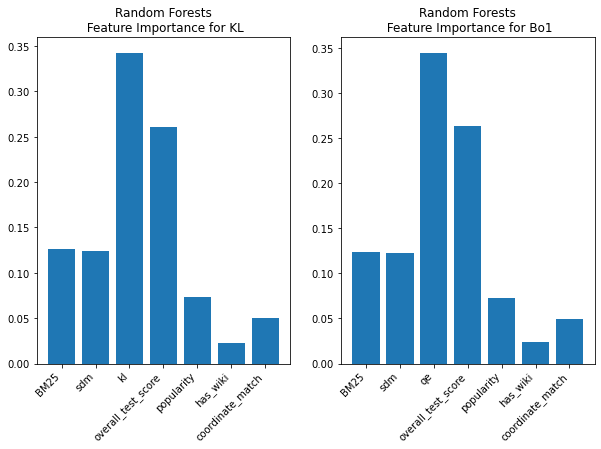

In [50]:


%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))

ax0.bar(np.arange(len(fnames1_1)), rf1_1.feature_importances_)
ax0.set_xticks(np.arange(len(fnames1_1)))
ax0.set_xticklabels(fnames1_1, rotation=45, ha='right')
ax0.set_title("Random Forests\n Feature Importance for KL")

ax1.bar(np.arange(len(fnames1_2)), rf1_2.feature_importances_)
ax1.set_xticks(np.arange(len(fnames1_2)))
ax1.set_xticklabels(fnames1_2, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance for Bo1")


fig.show()

## Feature Importance

It could be seen that has_wiki is not a very important factor(coordinate match is also not very important), so we try to remove it

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:



ltr_feats1_2_1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ['docno', 'title', 'synopsis','score', 'wiki_intro', 'review','popularity',])>>  (
    pt.transformer.IdentityTransformer()
    **
    sdm
    **
    pipeline_qe
    ** # score of title (not originally indexed)
    
    (pt.text.scorer(body_attr="title", wmodel='TF_IDF')*3
    +pt.text.scorer(body_attr="synopsis",wmodel='BM25')*2+pt.text.scorer(body_attr="wiki_intro",wmodel='BM25')*2
    +pt.text.scorer(body_attr="review",wmodel='BM25'))
    **
    (pt.apply.doc_score(lambda row: int(row["popularity"])))
    **
    (pt.apply.doc_score(lambda row: (float)(row['score'])))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="PL2")
)

fnames1_2_1=["BM25","sdm", "qe", 'overall_test_score', 'popularity', "score",  "PL2"]

In [53]:
SEED=42
RANK_CUTOFF=50


rf1_2_1 = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe1_2_1 = ltr_feats1_2_1 >> pt.ltr.apply_learned_model(rf1_2_1)
%time rf_pipe1_2_1.fit(train_query, df_label_train)

14:13:34.993 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:13:35.614 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:13:36.439 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:13:38.506 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

CPU times: user 43.6 s, sys: 1.27 s, total: 44.8 s
Wall time: 41.4 s


/tmp/ipykernel_500824/359242107.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


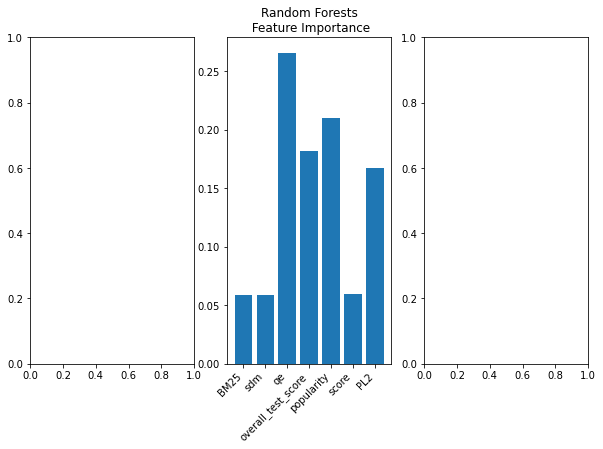

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))


ax1.bar(np.arange(len(fnames1_2_1)), rf1_2_1.feature_importances_)
ax1.set_xticks(np.arange(len(fnames1_2_1)))
ax1.set_xticklabels(fnames1_2_1, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

fig.show()


In [55]:
from pyterrier.measures import *

# training set
pt.Experiment(
    [bm25,bm25_150,random_model,rf_pipe1_2,rf_pipe1_2_1],
    df_query_train,
    df_label_train,
    names=["BM25","BM25_150","Naive","rf_qe","rf_qe_revised"], 
    eval_metrics=["map", "ndcg",nDCG@5,nDCG@10,nDCG@15,nDCG@20,'P.10','mrt',Recall@15])
# ,"RF1","LMart1" rf_pipe1,lmart_x_pipe1

14:15:03.310 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:15:03.924 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:15:04.755 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:15:06.881 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

14:15:44.002 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:15:44.618 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:15:45.456 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
14:15:47.522 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/home/zihuiliu/.local/lib/python3.9/site-packages/pyterrier/ops.py:241: UserWarning: Got number of results different expected from ComposedPipeline(ComposedPipeline(BR(/home/zihuiliu/project/pt_index_with_stemming/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatchin

,name,map,ndcg,nDCG@5,nDCG@10,nDCG@15,nDCG@20,P.10,R@15,mrt
0,BM25,0.630514,0.786125,0.559727,0.502798,0.492524,0.488709,0.650,0.114582,667.330531
1,BM25_150,0.612363,0.763037,0.559727,0.502798,0.492524,0.488709,0.650,0.114582,671.712175
2,Naive,0.279768,0.631717,0.343793,0.337517,0.330943,0.328125,0.495,0.085620,857.603404
3,rf_qe,0.354050,0.516948,0.962696,0.903868,0.855780,0.808860,0.995,0.177496,1944.115730
4,rf_qe_revised,0.354419,0.517472,0.961084,0.909562,0.857717,0.813662,0.995,0.178880,1935.064700
